In [9]:
import math
from unhippo.lds import UnHiPPOSystem
import torch
import scipy.linalg
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm

In [3]:
n = 128
hippo = UnHiPPOSystem(n, regularize_derivatives=1)
A = hippo.system_dynamics_matrix()

In [20]:
k = 5
I = torch.eye(n)
M = I - alpha * A.compute(k)

alphas = np.linspace(0.7, 1, 10_000)
ks = [1, 5, 10, 20, 50]
A_k = {k: A.compute(k) for k in ks}
conds = np.array([[torch.linalg.cond(I - alpha * A_k[k]) for alpha in tqdm(alphas)] for k in ks])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

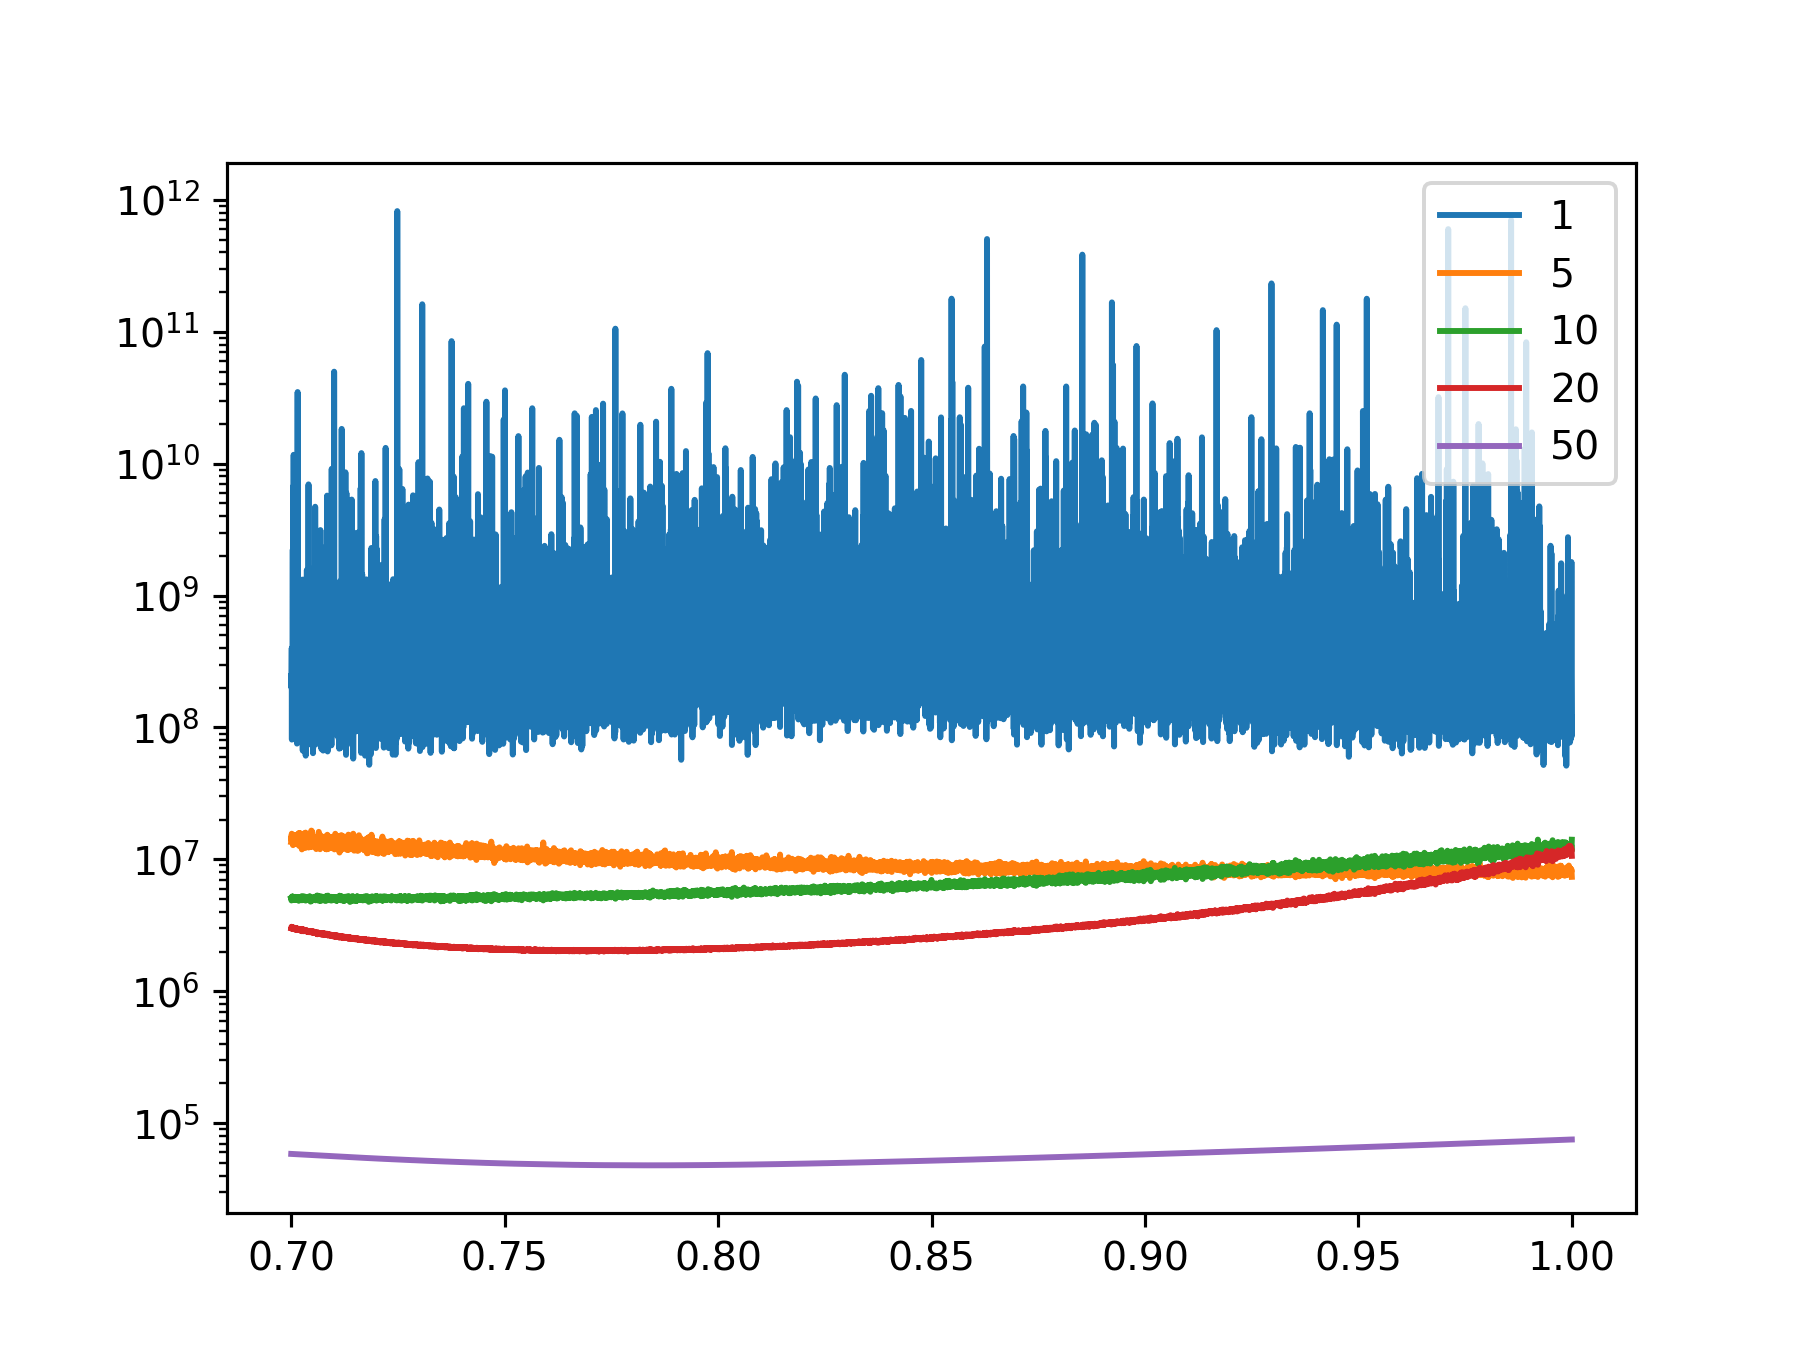

In [21]:
for k, cond in zip(ks, conds):
    pp.plot(alphas, cond, label=str(k))
pp.yscale("log")
pp.legend()

In [30]:
def lower_bound(alpha, k, D):
    if alpha > 2 * (k + 1) / D:
        num = (alpha * D) / (k + 1) - 1
    else:
        num = 1
    if alpha < (k + 1) / D:
        denom = 1 - (alpha * D) / (k + 1)
    else:
        denom = abs(min(1 - alpha / (k + 1) * math.floor((k + 1) / alpha), alpha / (k + 1) * math.ceil((k + 1) / alpha) - 1))
    if denom == 0:
        return np.inf
    else:
        return num / denom

In [151]:

np.linalg.det(M), np.linalg.norm(M, ord="fro")**D

(2.1939908796168044e-09, 1.2010858148358857e+41)

In [260]:
As = {}
Is = {}
def cond_IA(alpha, k, D):
    if D + 1 not in As:
        As[D + 1] = unhippo_matrix(D + 1).numpy().astype(np.double)
    A = As[D + 1]
    if D + 1 not in Is:
        Is[D + 1] = np.identity(D + 1)
    I = Is[D + 1]

    return np.linalg.cond(I - alpha / (k + 1) * A)

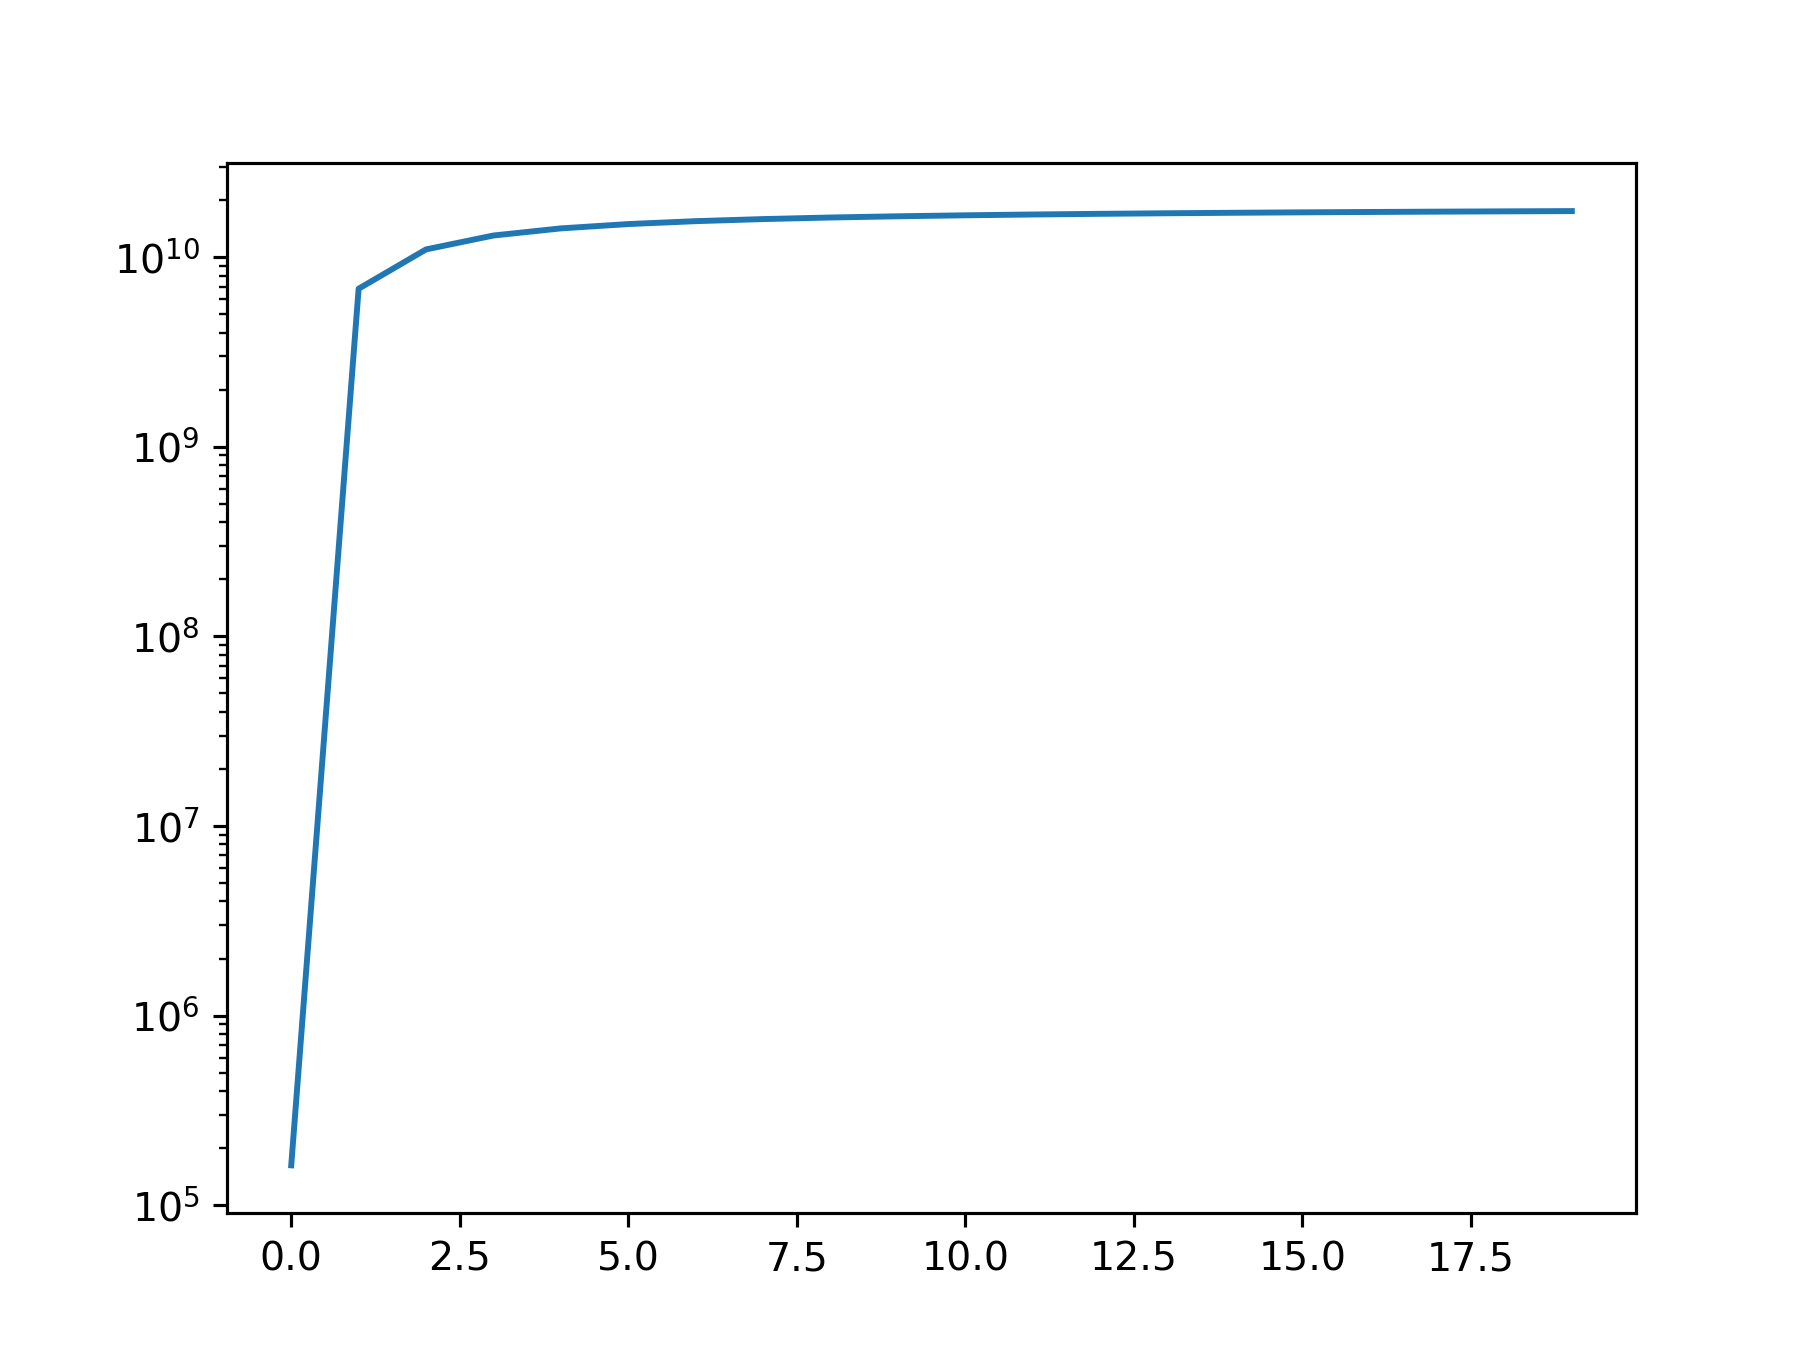

In [300]:
D = 128
conds = np.array([cond_IA(k / D / 6, k, D) for k in ks])
pp.plot(conds)
pp.yscale("log")

In [472]:
np.log(10**10)

23.025850929940457

In [453]:
ks = np.linspace(1, 400, 10).astype(int)
Ds = np.linspace(1, 256, 10).astype(int)
Bs = np.logspace(2, 15, 20)

alphas = np.array([[[conditioned_alpha(B, k, D) for B in Bs] for D in Ds] for k in ks])

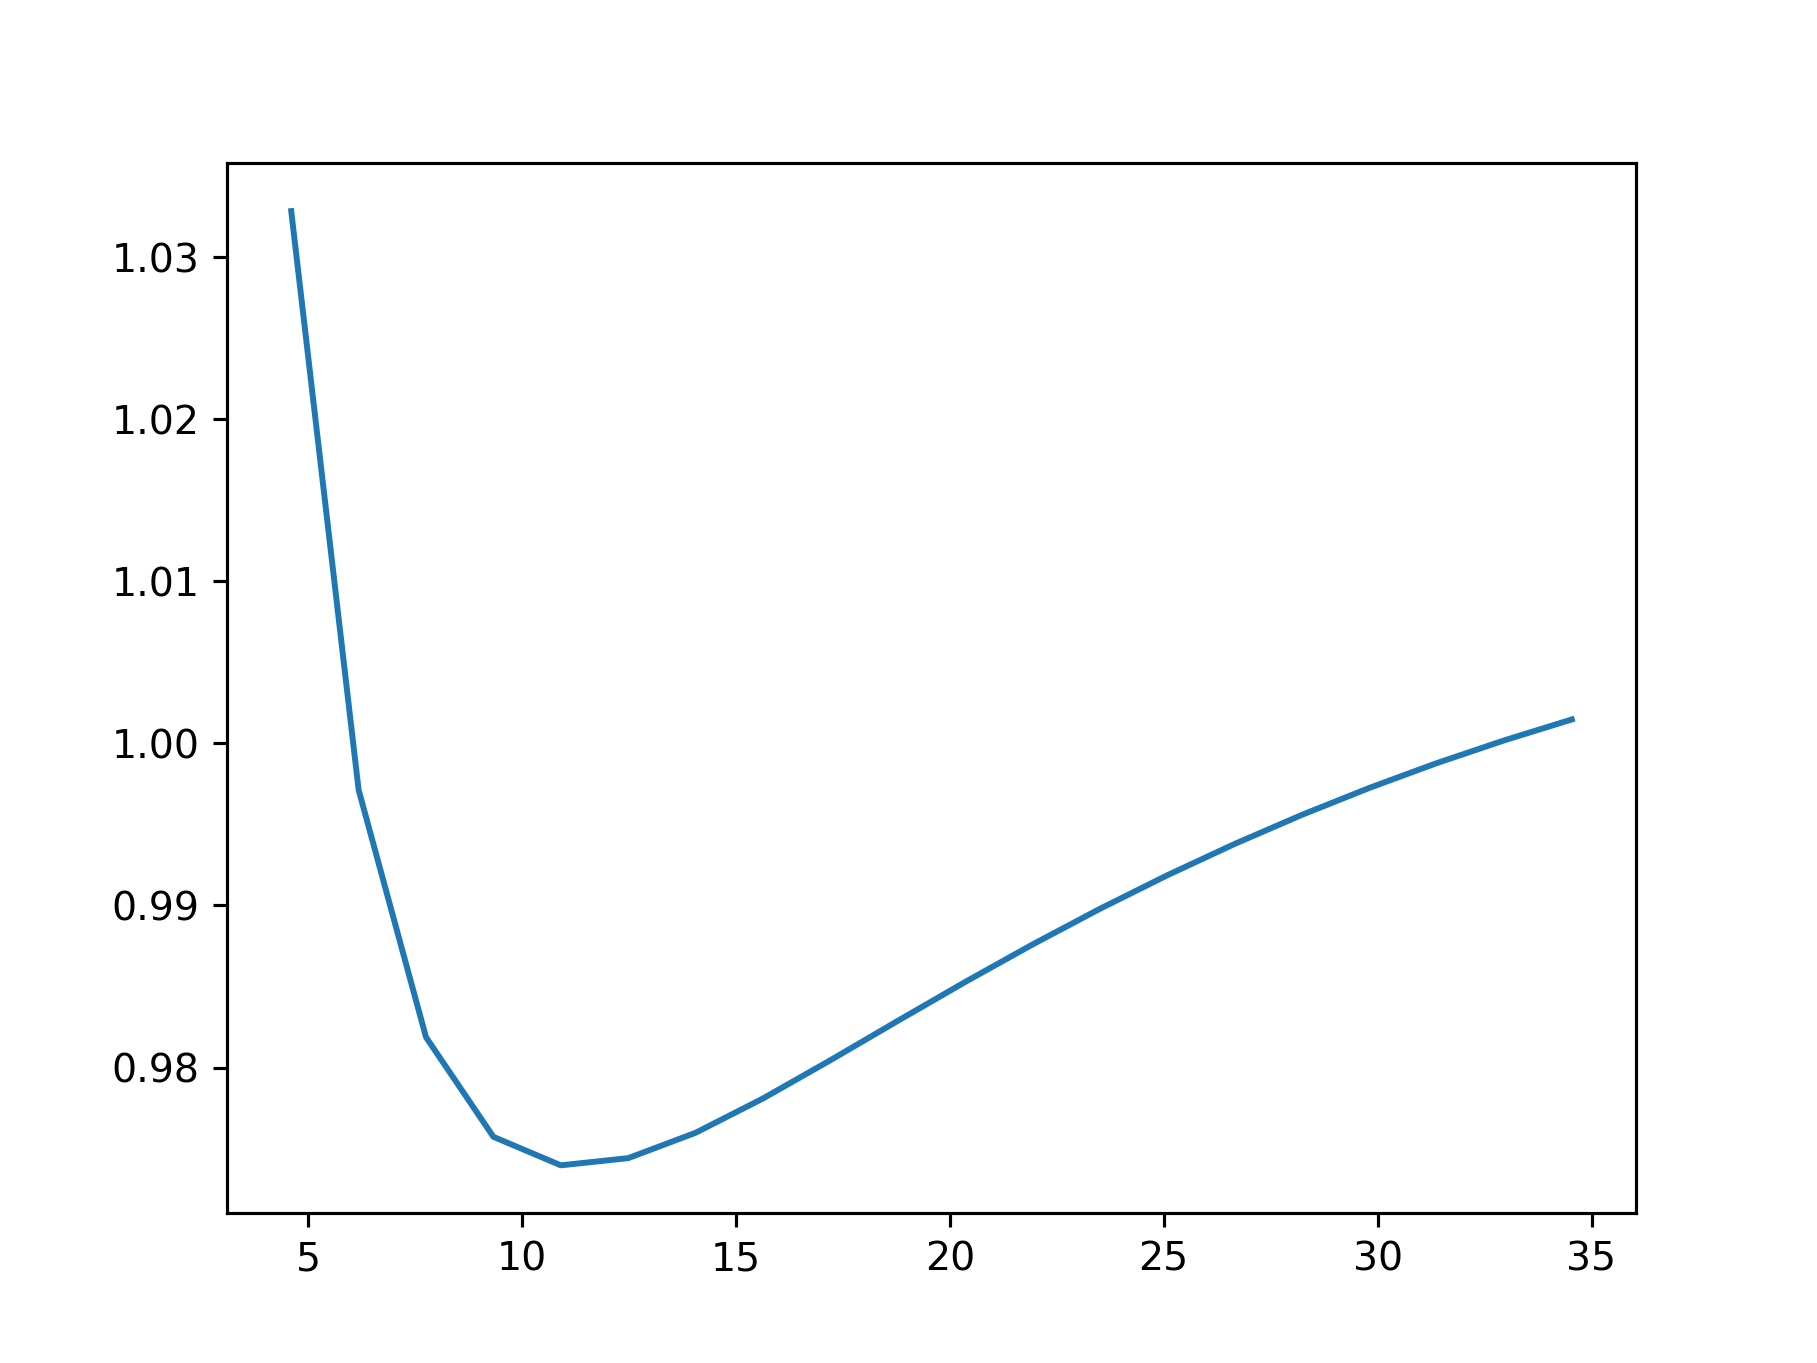

In [471]:
i, j = 4,6
pp.plot(np.log(Bs), alphas[i, j] / (((ks[i] / Ds[j]) / (0.047 * Ds[j] + 0.126)) * 0.044 * np.log(Bs)))
#pp.xscale("log")

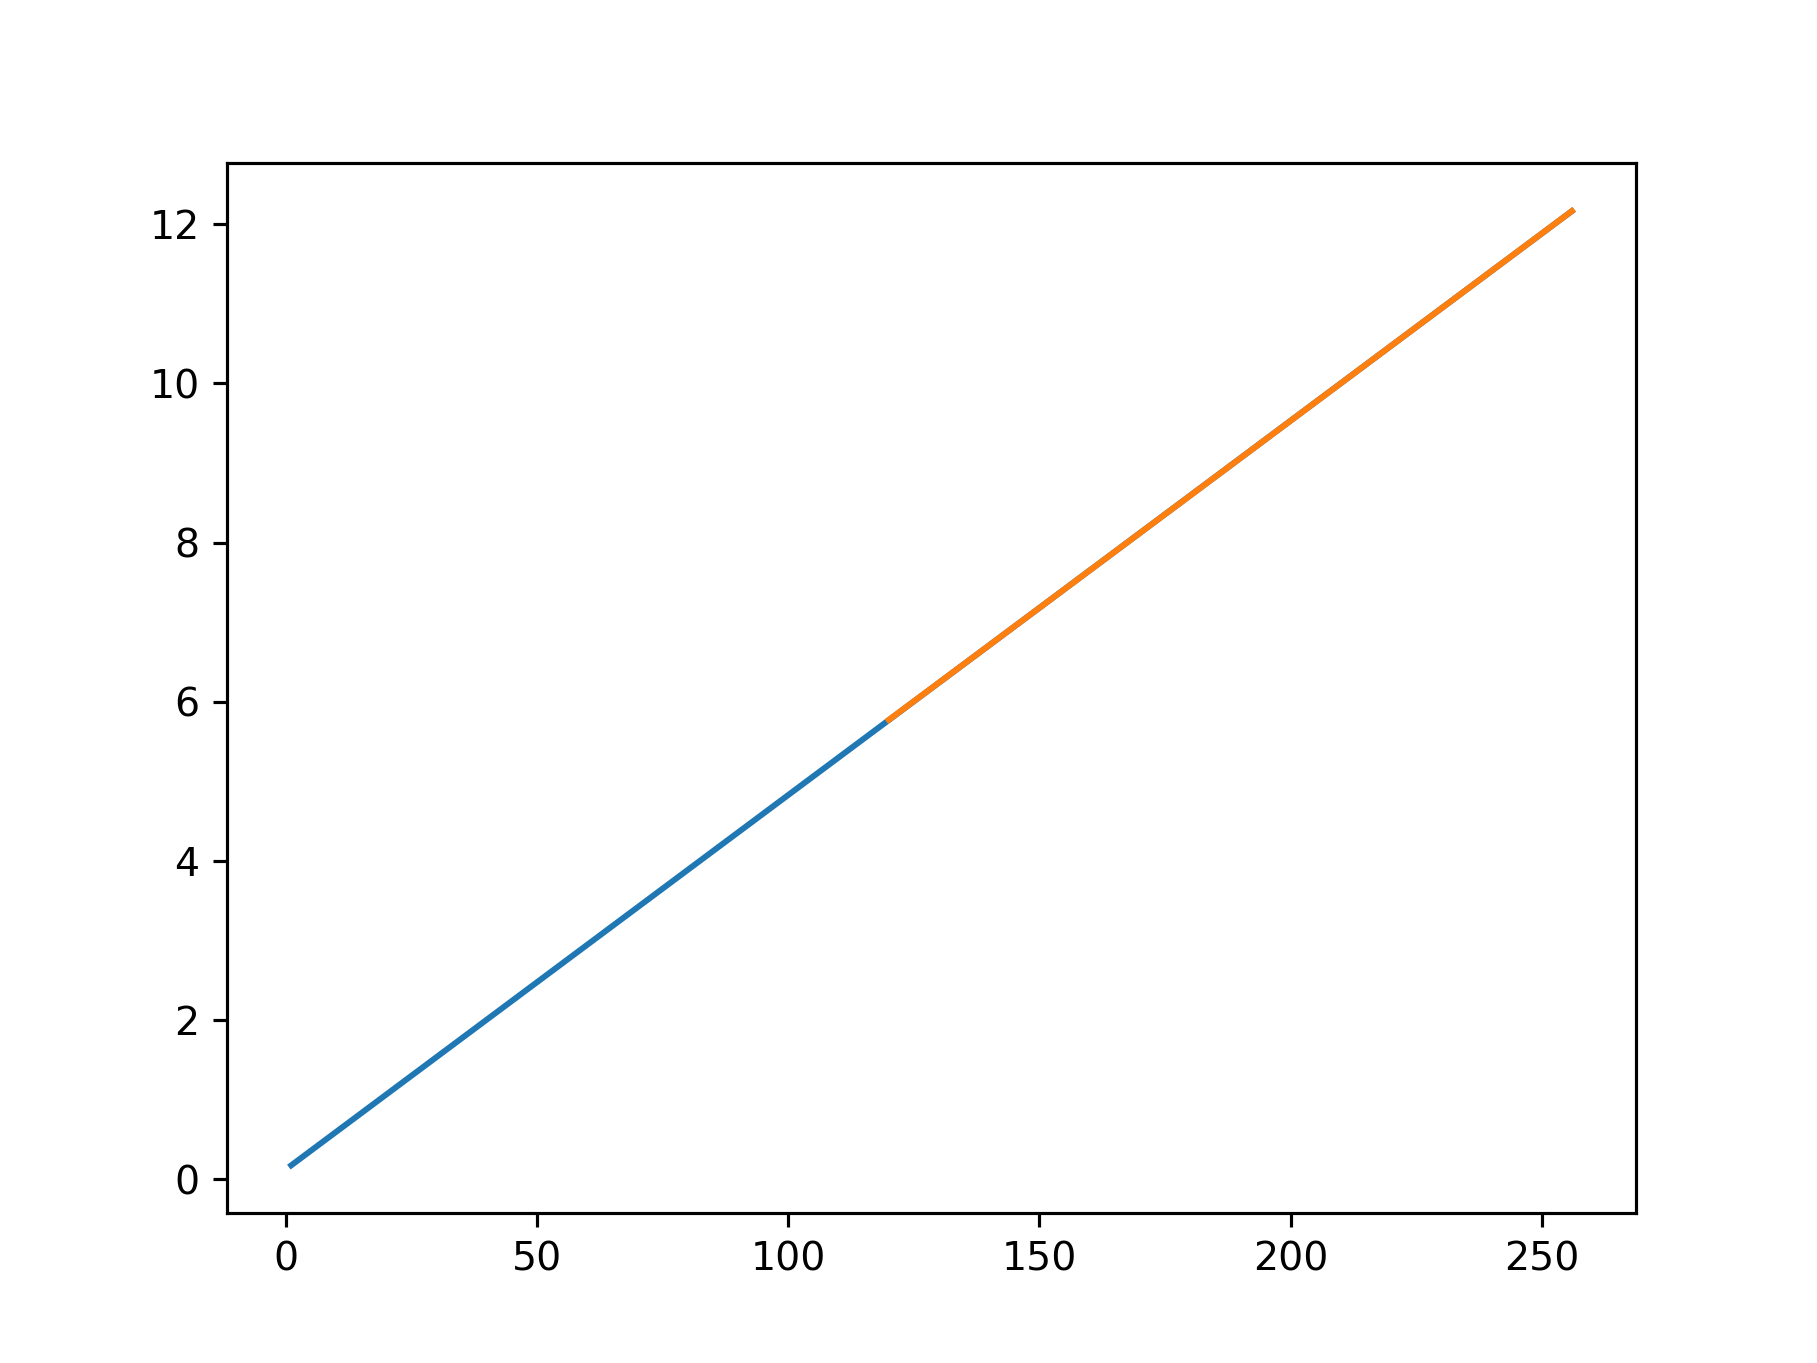

In [445]:
poly = np.polynomial.Polynomial.fit(Ds[25:], ((ks[i] / Ds) / alphas[i])[25:], deg=1).convert(kind=np.polynomial.Polynomial)
pp.plot(Ds, poly(Ds))
pp.plot(Ds, (ks[i] / Ds) / alphas[i], label="ratio")
# pp.plot(Ds, alphas[i])
# pp.plot(Ds, (1 / Ds) / poly(Ds), label="ratio", ls="--")
# pp.ylim((0, 1))

In [385]:
f = lambda k: ((1 / Ds) / alphas[i])[k]

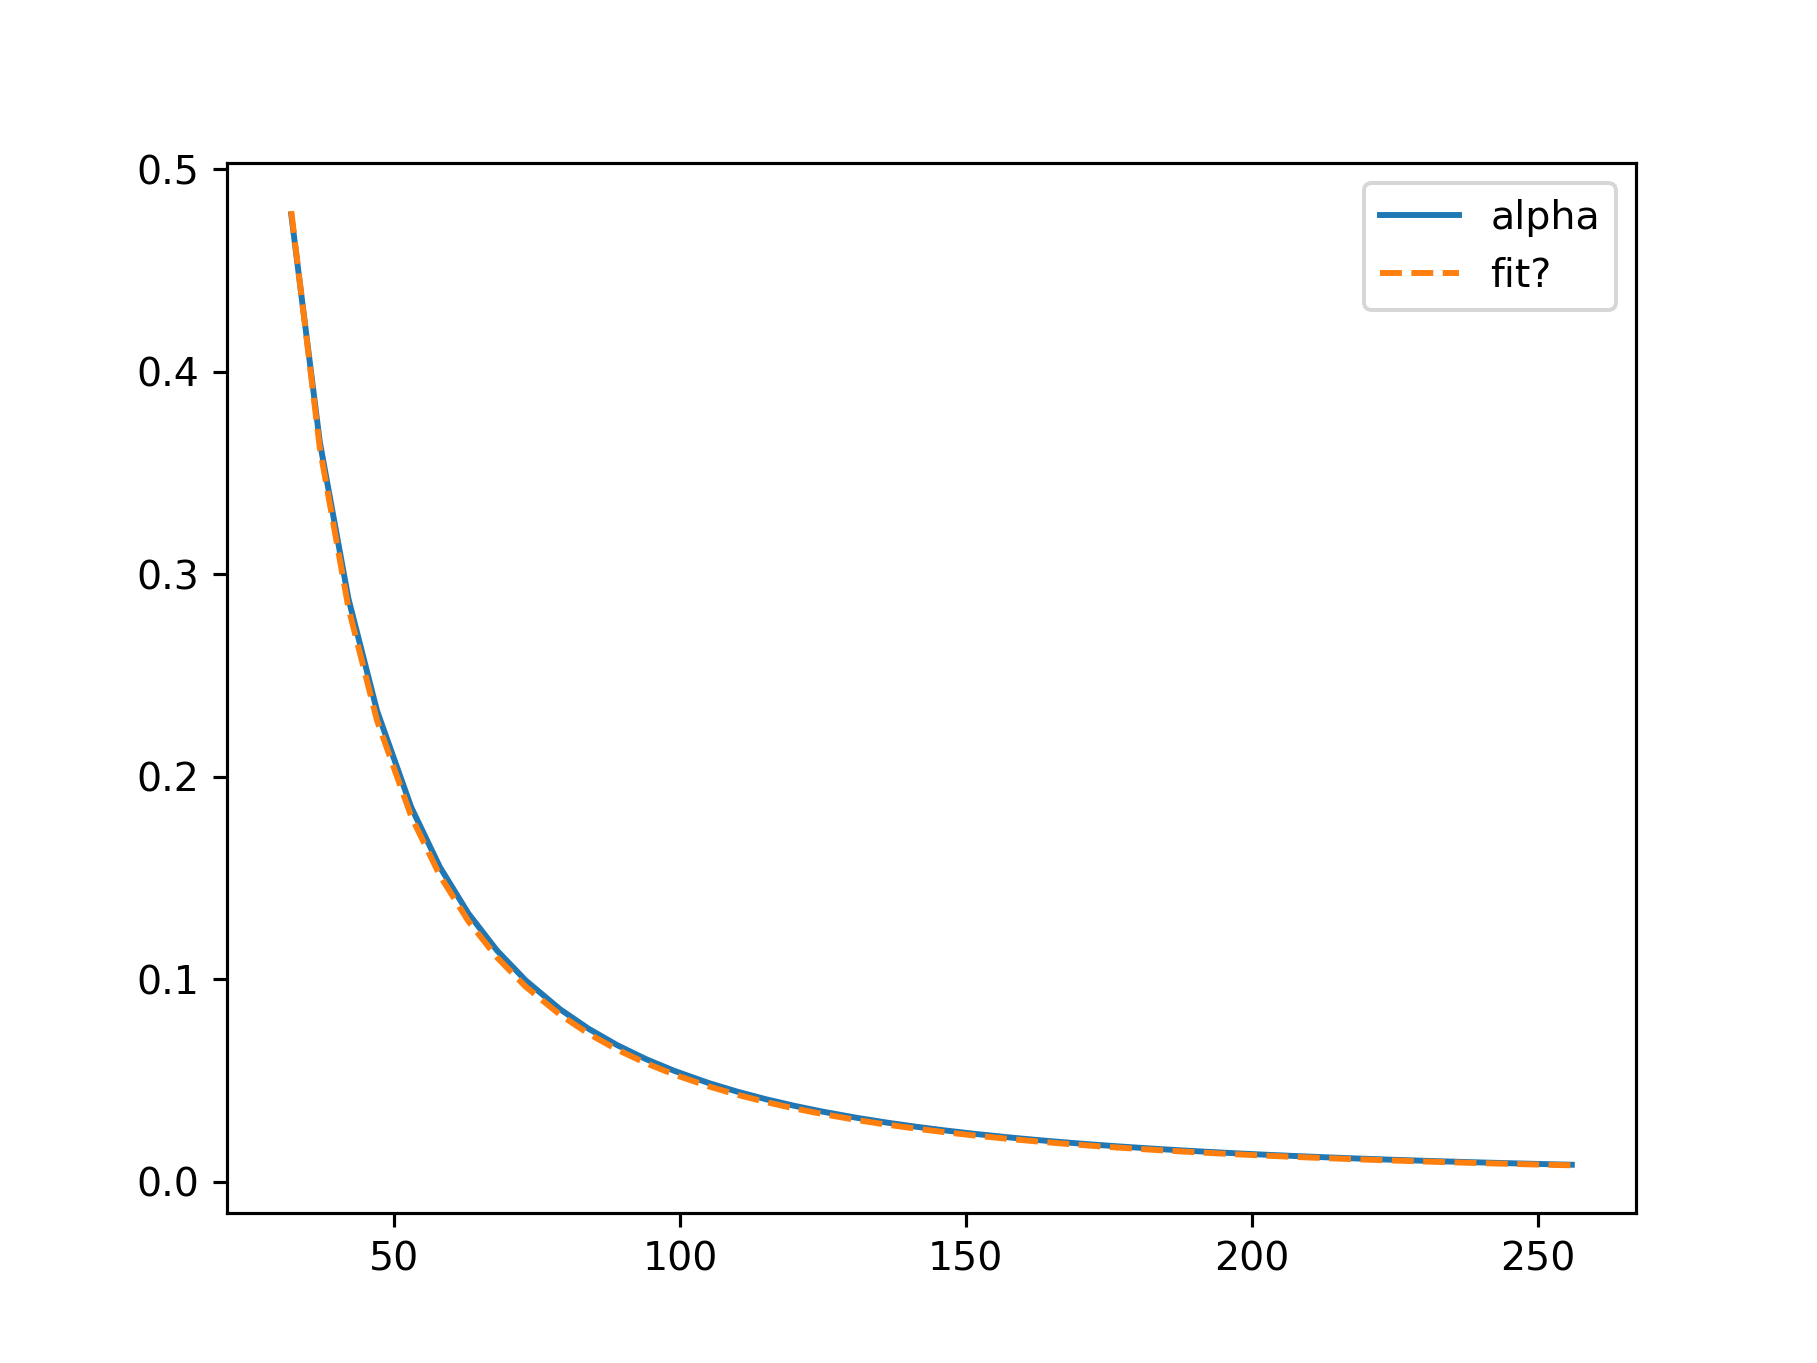

In [452]:
i = 3
pp.plot(Ds, alphas[i], label="alpha")
#pp.plot(Ds, np.where(np.isnan(alphas[i]), np.nan, (1 / Ds)), label="upper limit")
#pp.plot(Ds, (1 / Ds) / alphas[i], label="ratio")
#pp.plot(Ds, np.where(np.isnan(alphas[i]), np.nan, (1 / Ds) / (0.048 * Ds + 0.016)), label="fit?")
pp.plot(Ds, np.where(np.isnan(alphas[i]), np.nan, (ks[i] / Ds) / (0.047 * Ds + 0.126)), label="fit?", ls="--")
pp.legend()

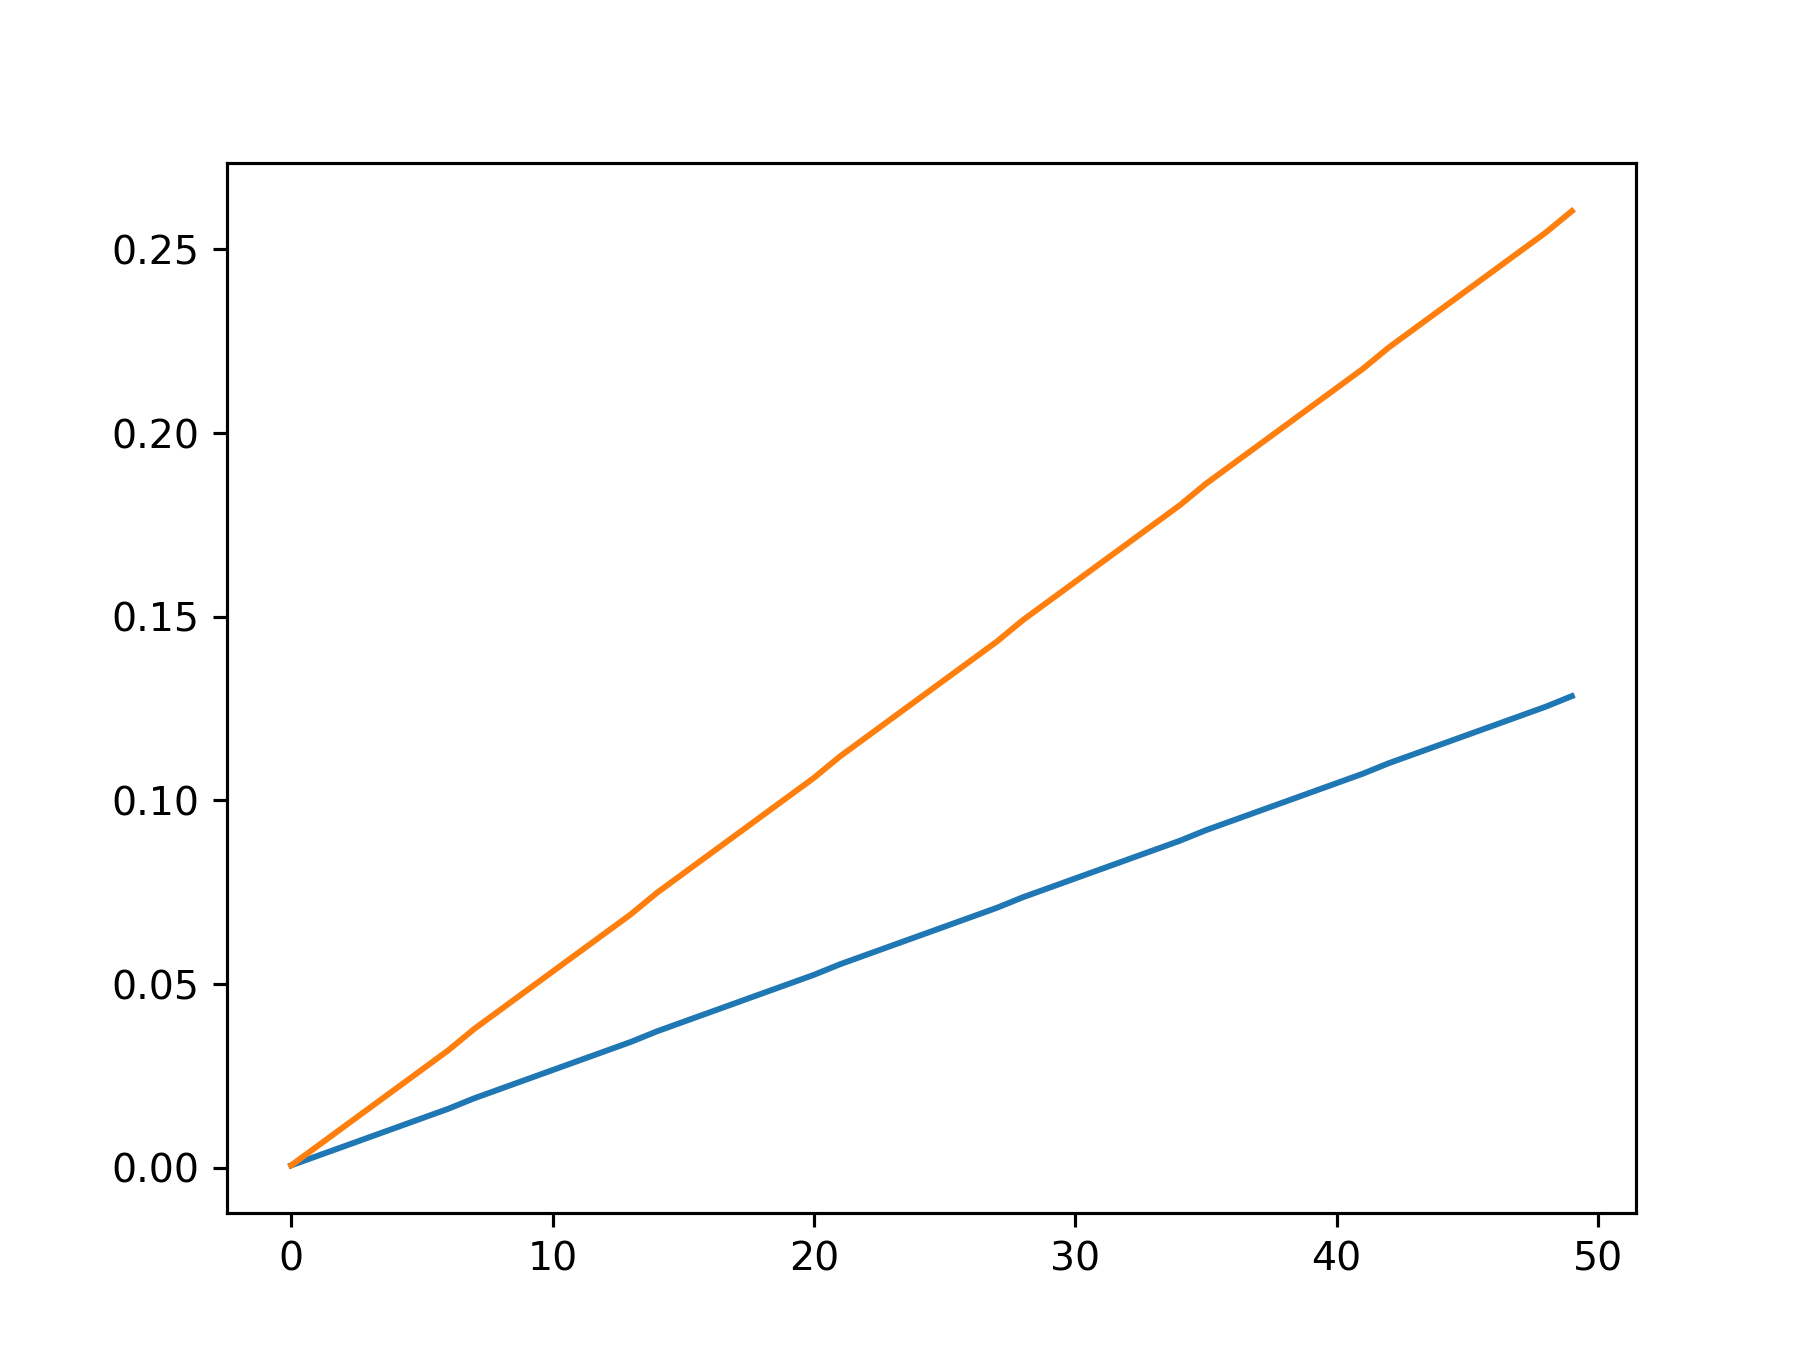

In [352]:
pp.plot(alphas[:, -1])
pp.plot(ks / Ds[-1] / 6)

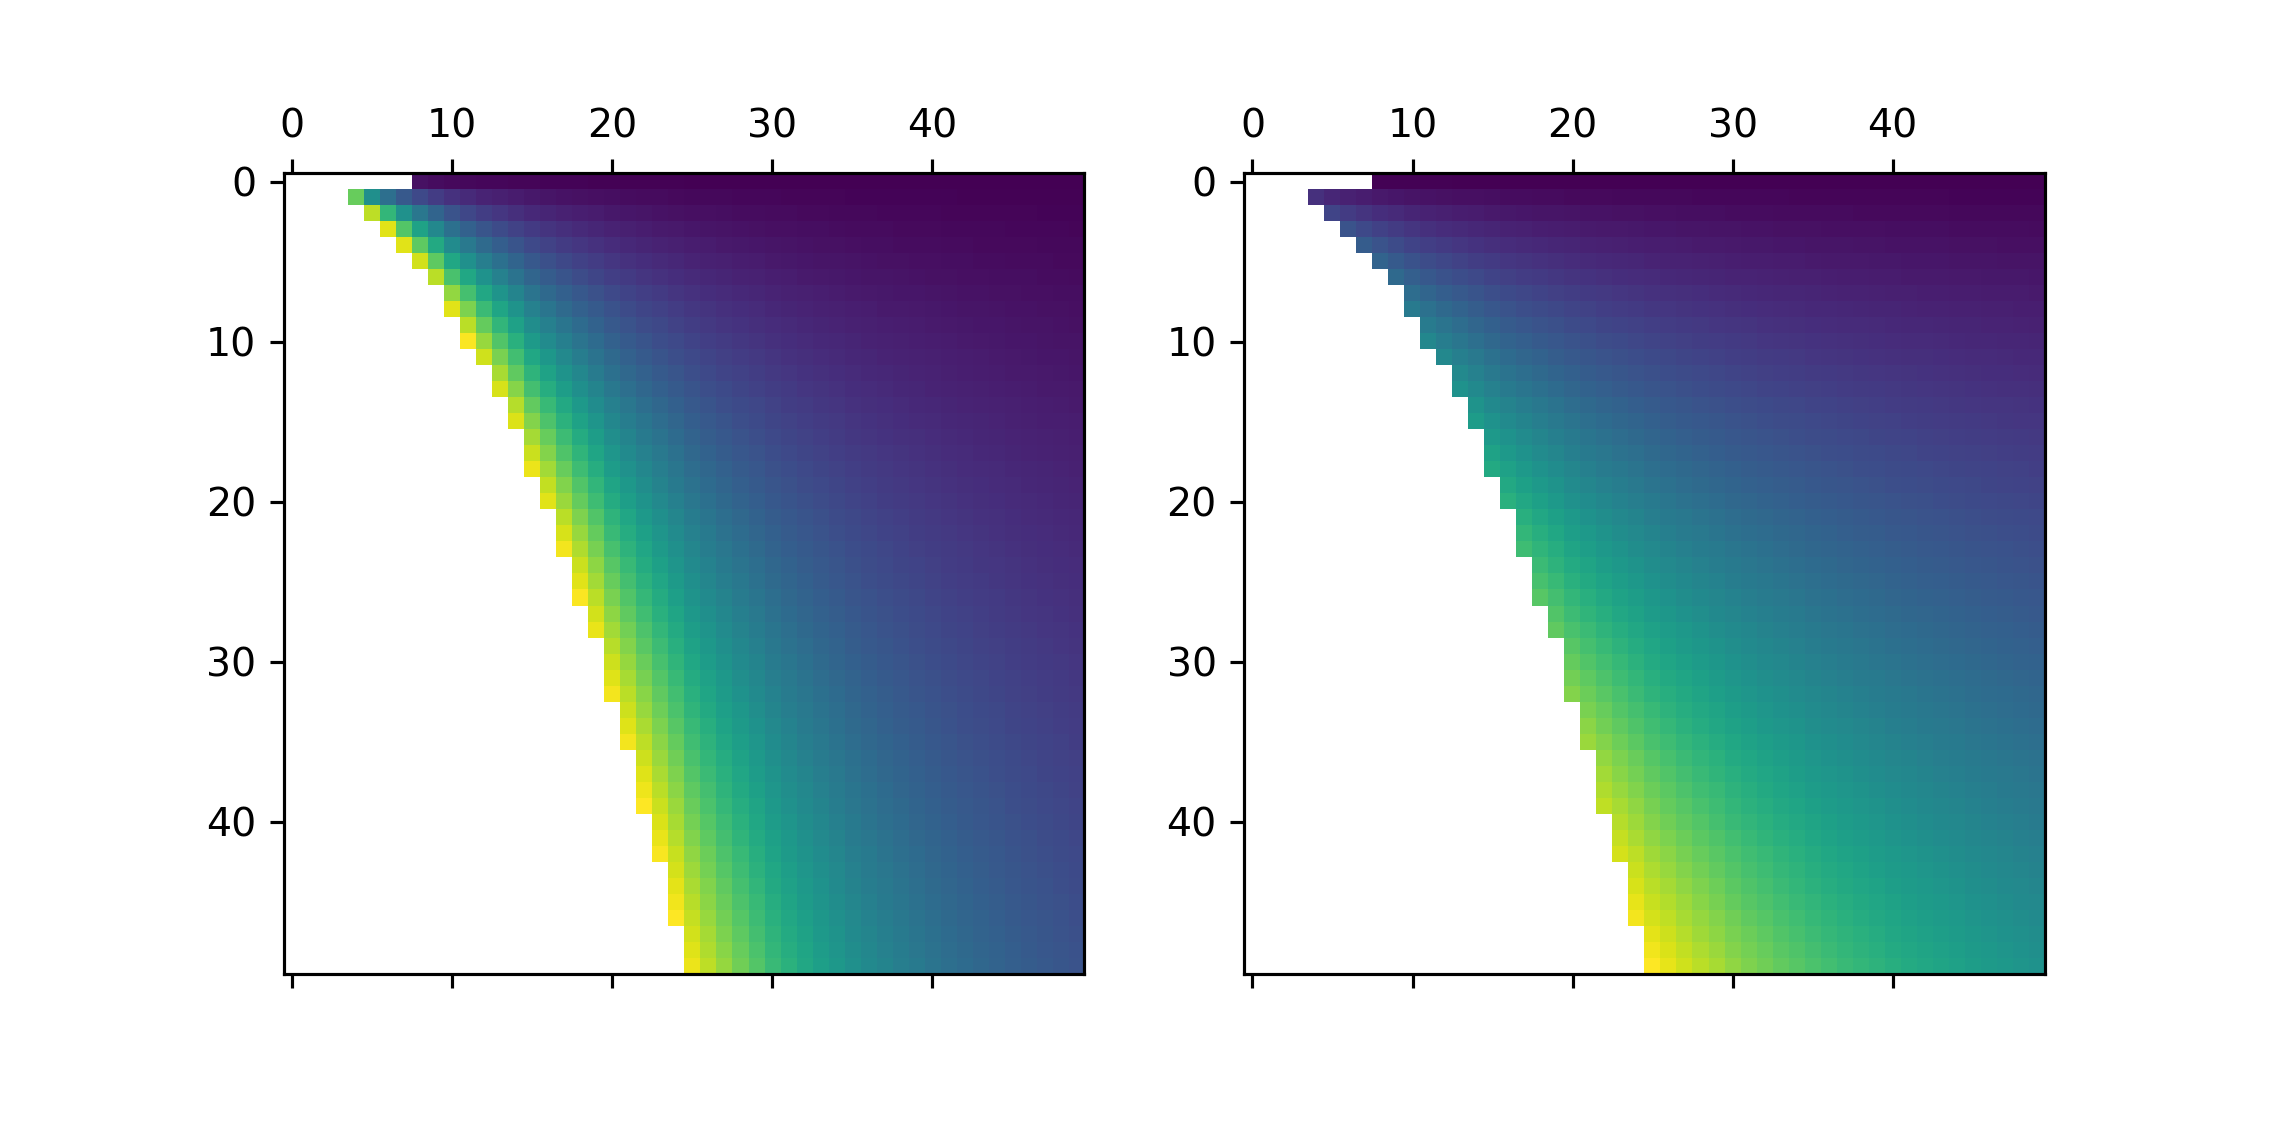

In [351]:
alpha_limits = np.where(np.isnan(alphas), np.nan, ks[:, None] / Ds[None])
fig = pp.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.matshow(alphas)
ax = fig.add_subplot(122)
ax.matshow(alpha_limits)
#pp.colorbar()

In [279]:
def conditioned_alpha(B, k, D):
    try:
        res = root_scalar(lambda x: cond_IA(x, k, D) - B, bracket=(0, min(k / D, 0.5)))
    except ValueError:
        return np.nan
    if res.converged:
        return res.root
    else:
        return np.nan

In [258]:
k = 30
D = 32
alphas = np.linspace(0, 1, 100)
cond_lb = np.array([lower_bound(alpha, k, D) for alpha in alphas])

A = unhippo_matrix(D + 1).numpy().astype(np.double)
I = np.identity(D + 1)
cond = np.array([np.linalg.cond(I - alpha / (k + 1) * A) for alpha in alphas])

def upper_bound(A):
    n = A.shape[0]
    return 2 / abs(np.prod(np.diag(A))) * (np.linalg.norm(A, ord="fro") / np.sqrt(n))**n
cond_ub = np.array([upper_bound(I - alpha / (k + 1) * A) for alpha in alphas])

def upper_bound2(A, k, D, alpha):
    n = A.shape[0]
    D = n - 1
    if alpha < (k + 1) / D:
        #return np.exp(np.log(2) - D / 2 * np.log(D) - D * np.log(1 - alpha * D / (k + 1)) + D / 2 * np.log(np.linalg.norm(A, ord="fro")**2))
        #frob_norm_sq = np.sum((1 - alpha / (k + 1) * np.arange(n))) + (alpha / (k + 1))**2 * np.sum(np.triu(A, k=2)**2)
        frob_norm_sq = np.sum((1 - alpha / (k + 1) * np.arange(n))) + (alpha / (k + 1))**2 * np.sum(np.triu(A, k=2)**2)
        #return np.exp(np.log(2) - D / 2 * np.log(D) - D * np.log(1 - alpha * D / (k + 1)) + D / 2 * np.log(frob_norm_sq))
        #return frob_norm_sq
        return np.exp(np.log(2) - D / 2 * np.log(D) + D * alpha * D / (k + 1) + D / 2 * np.log(frob_norm_sq))
    else:
        return np.inf
cond_ub2 = np.array([upper_bound2(A, k, D, alpha) for alpha in alphas])

/tmp/ipykernel_334363/3406279053.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return 2 / abs(np.prod(np.diag(A))) * (np.linalg.norm(A, ord="fro") / np.sqrt(n))**n


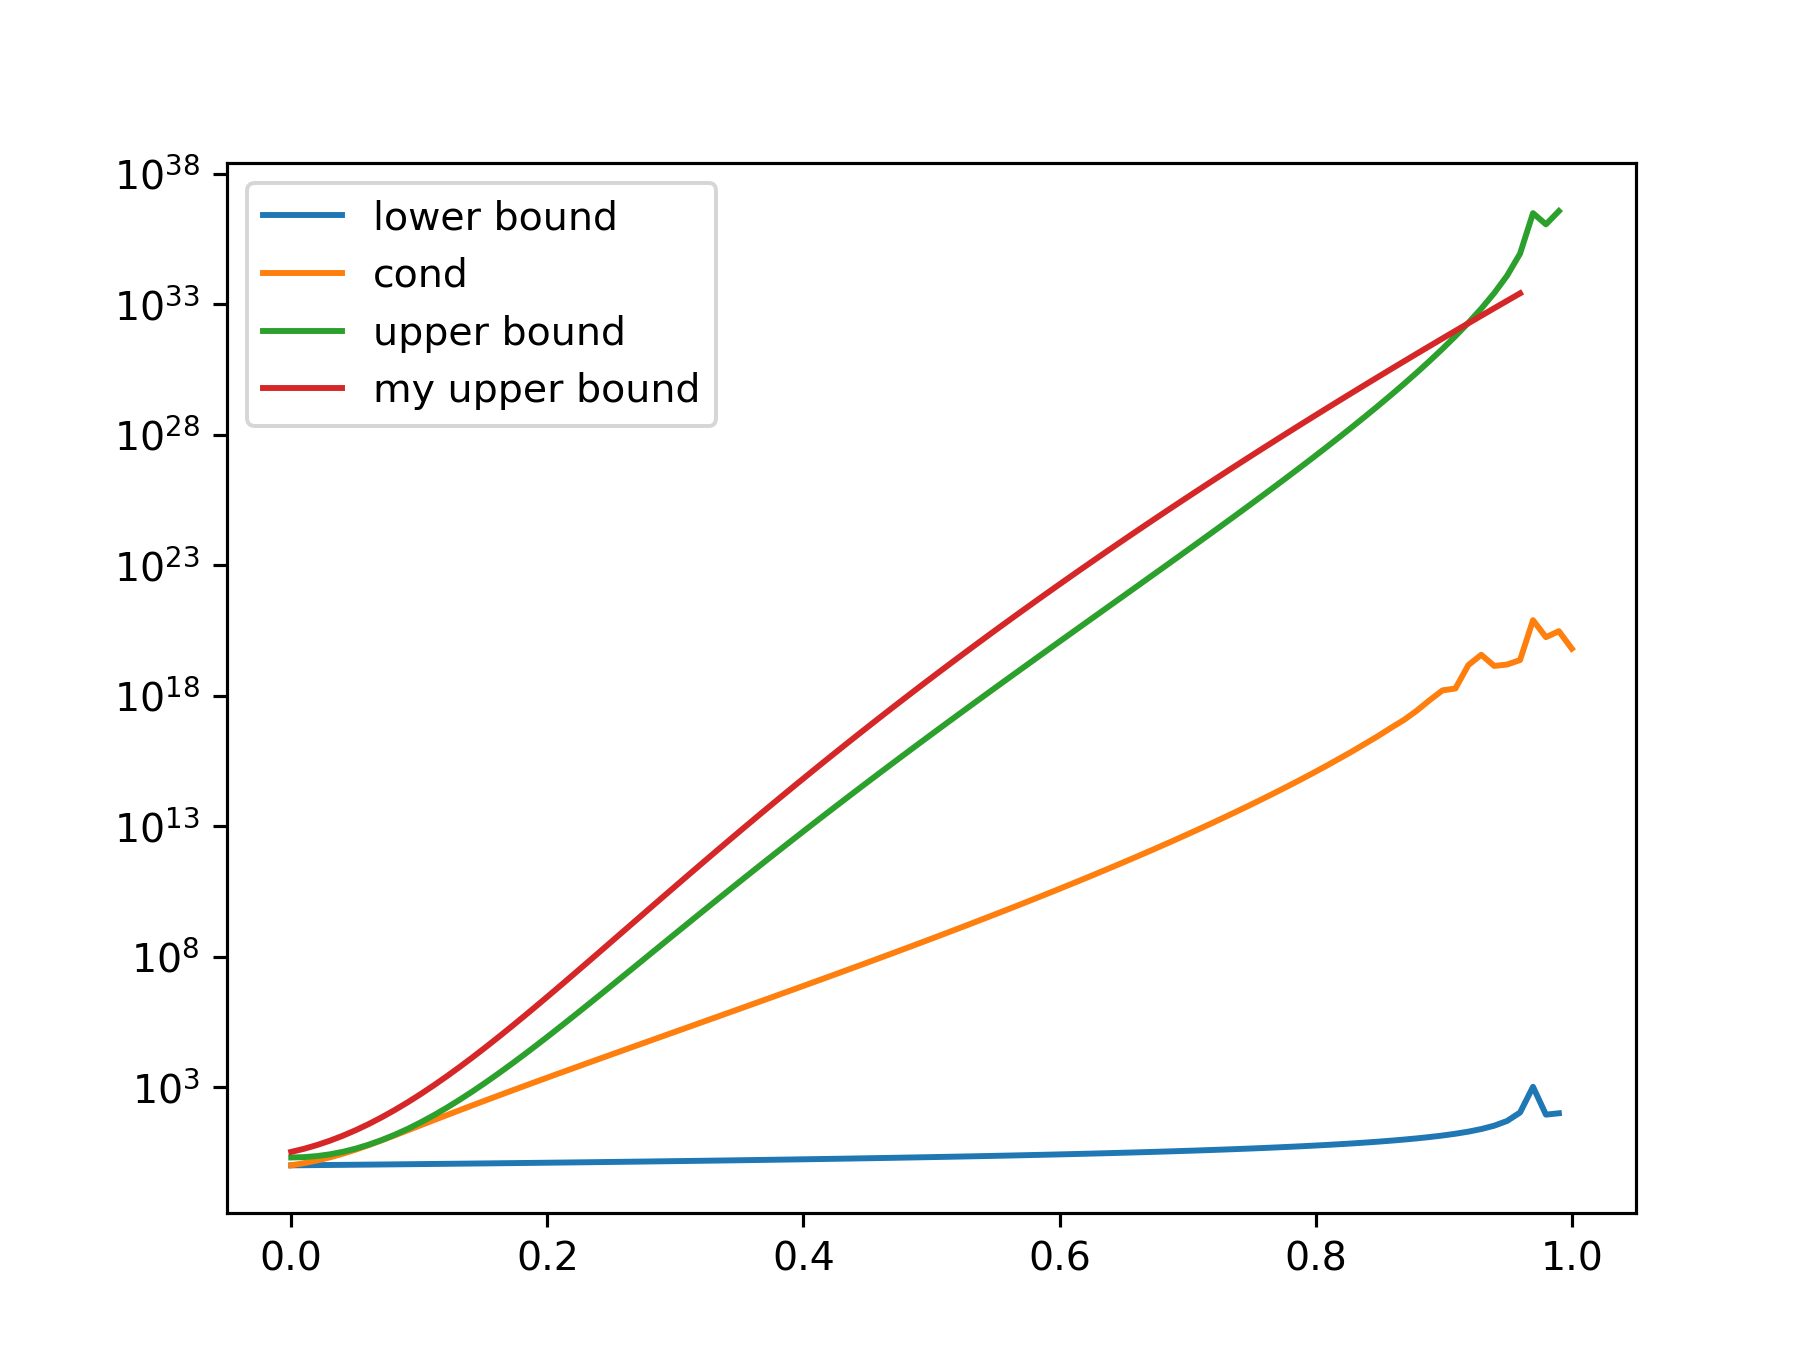

In [259]:
pp.plot(alphas, cond_lb, label="lower bound")
pp.plot(alphas, cond, label="cond")
pp.plot(alphas, cond_ub, label="upper bound")
pp.plot(alphas, cond_ub2, label="my upper bound")
pp.yscale("log")
pp.legend()
#pp.plot(alphas, np.exp(160 * alphas))
#pp.xlim((0, 0.2))
#pp.ylim((0, 10**3))

In [252]:
def x(B: float, D: int, k: int):
    A = unhippo_matrix(D + 1)
    poly = D * (D + 1) * (D + 2) / 6 + (np.triu(A, k=1)**2).sum()
    print((np.exp((np.log(B) - np.log(2) + D / 2 * np.log(D) - D * (k + 1)) * (2 / D)) - D - 1) / poly)
    return (k + 1) * np.sqrt((np.exp((np.log(B) - np.log(2) + D / 2 * np.log(D) - D * (k + 1)) * (2 / D)) - D - 1) / poly)

In [253]:
B = 1e13
x(B, D, k)

-5.73921028466483e-05


/tmp/ipykernel_334363/976760743.py:5: RuntimeWarning: invalid value encountered in sqrt
  return (k + 1) * np.sqrt((np.exp((np.log(B) - np.log(2) + D / 2 * np.log(D) - D * (k + 1)) * (2 / D)) - D - 1) / poly)


nan